<a href="https://colab.research.google.com/github/SwaRna-777/Assignment1/blob/main/Bigdata_assignment_final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://cli.github.com/packages stable InRelease [3,917 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,749 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd6

In [3]:

# Importing Libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, month, year, to_date
import matplotlib.pyplot as plt
import numpy as np


#  Start Spark

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("WalmartSalesAnalysisFinal") \
    .getOrCreate()


# Load Datasets

sales_df = spark.read.csv("/content/sales data-set.csv", header=True, inferSchema=True)
features_df = spark.read.csv("/content/Features data set.csv", header=True, inferSchema=True)
stores_df = spark.read.csv("/content/stores data-set.csv", header=True, inferSchema=True)


print("Summary (features_df schema):")
features_df.printSchema()
print("Sales Rows:", sales_df.count())
print("Features Rows:", features_df.count())
print("Stores Rows:", stores_df.count())


#  Fix Date Format Properly

sales_df = sales_df.withColumn(
    "Date",
    to_date(col("Date"), "dd/MM/yyyy")
)

features_df = features_df.withColumn(
    "Date",
    to_date(col("Date"), "dd/MM/yyyy")
)

# Remove Duplicate Column Before Join

sales_df = sales_df.drop("IsHoliday")

# Join Datasets

df = sales_df.join(features_df, on=["Store", "Date"], how="inner")
df = df.join(stores_df, on="Store", how="inner")

print("Rows After Join:", df.count())


#  Basic Cleaning

df = df.filter(col("Weekly_Sales") > 0)

df = df.withColumn("Month", month(col("Date")))
df = df.withColumn("Year", year(col("Date")))

print("Rows After Cleaning:", df.count())

# Outlier Removal (IQR on Weekly_Sales)

q1 = df.approxQuantile("Weekly_Sales", [0.25], 0.01)[0]
q3 = df.approxQuantile("Weekly_Sales", [0.75], 0.01)[0]
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

df = df.filter((col("Weekly_Sales") >= lower) & (col("Weekly_Sales") <= upper))

print("Rows After Outlier Removal:", df.count())


#  Apply 80% Retention

df = df.sample(fraction=0.8, seed=42)
print("Rows After 80% Retention:", df.count())



Summary (features_df schema):
root
 |-- Store: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

Sales Rows: 421570
Features Rows: 8190
Stores Rows: 45
Rows After Join: 421570
Rows After Cleaning: 420212
Rows After Outlier Removal: 382921
Rows After 80% Retention: 306263


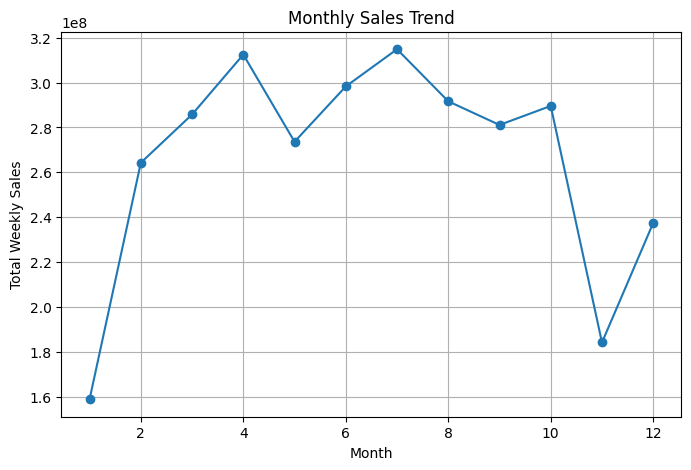

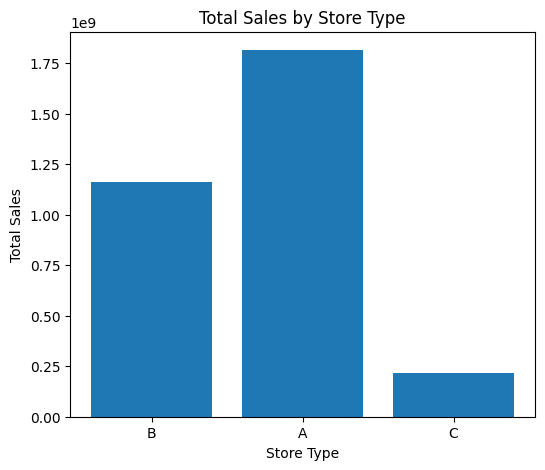

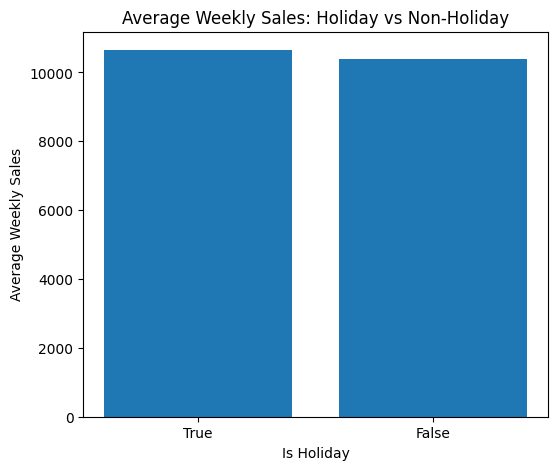

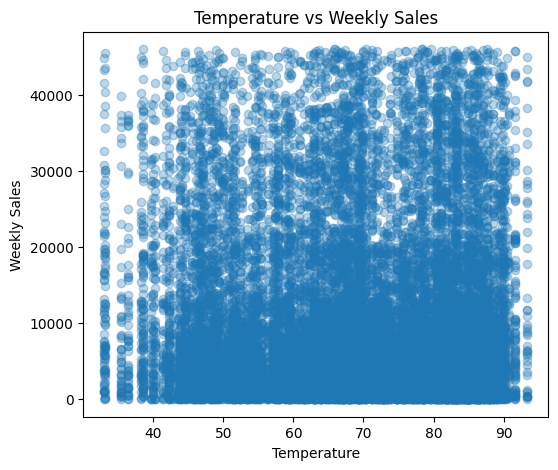

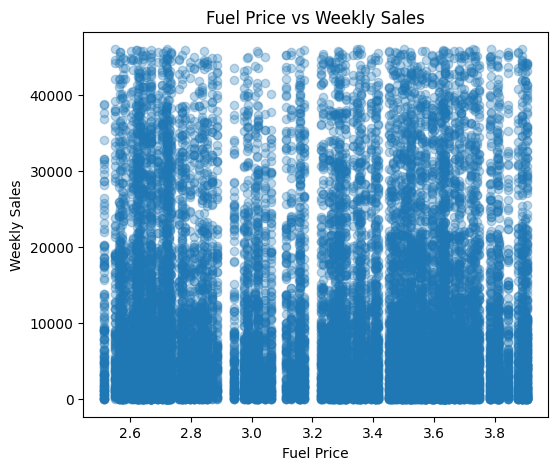

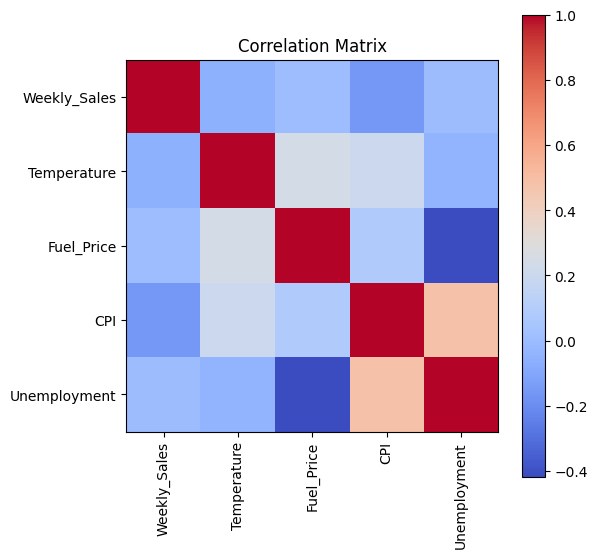

Correlation Matrix:
              Weekly_Sales  Temperature  Fuel_Price       CPI  Unemployment
Weekly_Sales      1.000000    -0.057297    0.008016 -0.156238      0.002436
Temperature      -0.057297     1.000000    0.243168  0.206972     -0.035336
Fuel_Price        0.008016     0.243168    1.000000  0.083444     -0.417138
CPI              -0.156238     0.206972    0.083444  1.000000      0.480514
Unemployment      0.002436    -0.035336   -0.417138  0.480514      1.000000
Final Analysis done.


In [4]:

# VISUAL ANALYSIS


#  Monthly Sales Trend
monthly_pd = df.groupBy("Month") \
    .agg(sum("Weekly_Sales").alias("TotalSales")) \
    .orderBy("Month") \
    .toPandas()

plt.figure(figsize=(8,5))
plt.plot(monthly_pd["Month"], monthly_pd["TotalSales"], marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Weekly Sales")
plt.grid(True)
plt.show()

# Store Type Performance

type_pd = df.groupBy("Type") \
    .agg(sum("Weekly_Sales").alias("TotalSales")) \
    .toPandas()

plt.figure(figsize=(6,5))
plt.bar(type_pd["Type"], type_pd["TotalSales"])
plt.title("Total Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Total Sales")
plt.show()


#  Holiday Impact

holiday_pd = df.groupBy("IsHoliday") \
    .agg(avg("Weekly_Sales").alias("AvgSales")) \
    .toPandas()

plt.figure(figsize=(6,5))
plt.bar(holiday_pd["IsHoliday"].astype(str), holiday_pd["AvgSales"])
plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.xlabel("Is Holiday")
plt.ylabel("Average Weekly Sales")
plt.show()

# ---------------------------
# 1Temperature vs Sales
# ---------------------------
temp_pd = df.select("Temperature", "Weekly_Sales") \
            .limit(20000) \
            .toPandas()

plt.figure(figsize=(6,5))
plt.scatter(temp_pd["Temperature"], temp_pd["Weekly_Sales"], alpha=0.3)
plt.title("Temperature vs Weekly Sales")
plt.xlabel("Temperature")
plt.ylabel("Weekly Sales")
plt.show()


# Fuel Price vs Sales

fuel_pd = df.select("Fuel_Price", "Weekly_Sales") \
            .limit(20000) \
            .toPandas()

plt.figure(figsize=(6,5))
plt.scatter(fuel_pd["Fuel_Price"], fuel_pd["Weekly_Sales"], alpha=0.3)
plt.title("Fuel Price vs Weekly Sales")
plt.xlabel("Fuel Price")
plt.ylabel("Weekly Sales")
plt.show()

#  Correlation Matrix

corr_cols = ["Weekly_Sales",
             "Temperature",
             "Fuel_Price",
             "CPI",
             "Unemployment"]

corr_pd = df.select(corr_cols).limit(30000).toPandas()
correlation = corr_pd.corr()

plt.figure(figsize=(6,6))
plt.imshow(correlation, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation Matrix")
plt.show()

print("Correlation Matrix:")
print(correlation)

print("Final Analysis done.")


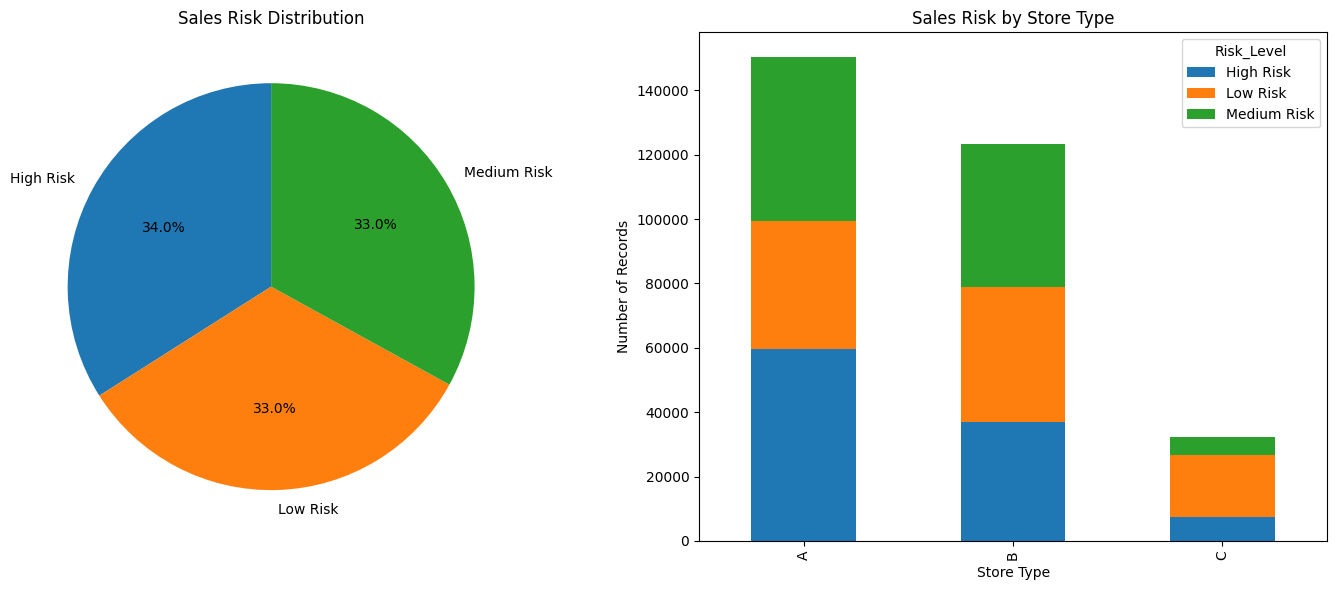

In [5]:

# VISUALISATION (Pie + Stacked Bar)


import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DF to Pandas for plotting
pdf = df.select("Weekly_Sales", "Type").toPandas()

# Create Risk Segmentation based on Sales

q1 = pdf["Weekly_Sales"].quantile(0.33)
q2 = pdf["Weekly_Sales"].quantile(0.66)

def classify_risk(sales):
    if sales >= q2:
        return "High Risk"
    elif sales >= q1:
        return "Medium Risk"
    else:
        return "Low Risk"

pdf["Risk_Level"] = pdf["Weekly_Sales"].apply(classify_risk)


# Create Figure Layout

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# 1️⃣ PIE CHART
risk_counts = pdf["Risk_Level"].value_counts()

axes[0].pie(
    risk_counts,
    labels=risk_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
axes[0].set_title("Sales Risk Distribution")

# 2️⃣ STACKED BAR CHART
risk_by_type = pd.crosstab(pdf["Type"], pdf["Risk_Level"])

risk_by_type.plot(
    kind="bar",
    stacked=True,
    ax=axes[1]
)

axes[1].set_title("Sales Risk by Store Type")
axes[1].set_xlabel("Store Type")
axes[1].set_ylabel("Number of Records")

plt.tight_layout()
plt.show()